In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

# Voting Classifiers

In [4]:
heads_proba = 0.51
np.random.seed(42)
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads = coin_tosses.cumsum(axis=0)
cumulative_heads_ratio = cumulative_heads / np.arange(1, 10001).reshape(-1, 1)

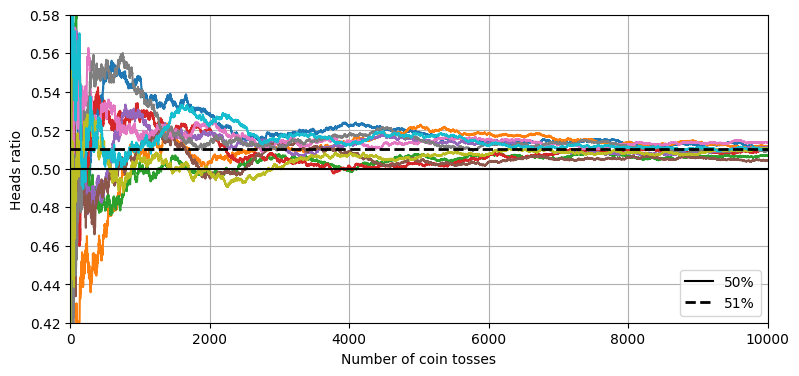

In [5]:
plt.figure(figsize=(9, 4))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.axis([0, 10000, 0.42, 0.58])
plt.legend(loc="lower right")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.grid()
plt.show()

Here, we will build  a voting classifier.

In [6]:
from sklearn.datasets import make_moons
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

X, y = make_moons(n_samples=500, noise=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

voting_clf = VotingClassifier(
    estimators=[
        ("lr", LogisticRegression(random_state=42)),
        ("rf", RandomForestClassifier(random_state=42)),
        ("svc", SVC(random_state=42)),
    ]
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

When you train `VotingClassifier`, it clones every estimators and fits the clones. The original estimators can be accessed via the `estimators` attribute, while the fitted estimators can be accessed via the `estimators_` attribute.

In [7]:
voting_clf.estimators

[('lr', LogisticRegression(random_state=42)),
 ('rf', RandomForestClassifier(random_state=42)),
 ('svc', SVC(random_state=42))]

In [8]:
voting_clf.estimators_

[LogisticRegression(random_state=42),
 RandomForestClassifier(random_state=42),
 SVC(random_state=42)]

If you prefer a dict instead of a list, you can use the attribute `named_estimators_` instead.

In [9]:
voting_clf.named_estimators_

{'lr': LogisticRegression(random_state=42),
 'rf': RandomForestClassifier(random_state=42),
 'svc': SVC(random_state=42)}

In [10]:
for name, classifier in voting_clf.named_estimators_.items():
    print(name, "=", classifier.score(X_test, y_test))

lr = 0.864
rf = 0.896
svc = 0.896


When you call the voting classifier's method `predict`, it performs the hard voting. 

In [11]:
voting_clf.predict(X_test[:1])

array([1])

The voting classifier asks all of its estimators to predict the instance, then check which class gets the most votes.

In [12]:
[clf.predict(X_test[:1]) for clf in voting_clf.estimators_]

[array([1]), array([1]), array([0])]

Let's see how it performs on the test set.

In [13]:
voting_clf.score(X_test, y_test)

0.912

And yes, the voting classifier outperform all the individual classifiers

You can use soft voting by setting the `voting` hyperparameter to `soft`. This will tell the model to estimate each individual's probabilities. In our case, the SVC don't estimate the probability by default, so you need to set its `probability=True`.

In [14]:
voting_clf.voting = "soft"
voting_clf.named_estimators["svc"].probability = True
voting_clf.fit(X_train, y_train)
voting_clf.score(X_test, y_test)

0.92

# Bagging and Pasting in Scikit-learn

You can use `BaggingClassifier` class for both bagging and pasting tasks. If you want to use pasting, just set `bootstrap=False`.

We will train 500 decision trees. Each of them is trained on 100 instances randomly sampled with replacement from the training dataset:
- `n_estimators`: The number of estimators
- `max_samples`: The max number of samples
- `n_jobs`: The number of CPU cores dedicated for the task, -1 means use all the possible cores.
- `bootstrap`: Default to True. If you want to use pasting instead of bagging, set it to False.

In [15]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators=500,
    max_samples=100,
    bootstrap=True,
    n_jobs=-1,
    random_state=42,
)
bag_clf.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1, random_state=42)

The `BaggingClassifier` uses soft voting instead of hard voting if the base classifier has a `predict_proba()` method (i.e. it can estimate the class probabilities), which is the case with decision tree classifiers.

In [16]:
def plot_decision_boundary(clf: sklearn.base.BaseEstimator, X, y, alpha=1.0):
    axes = [-1.5, 2.5, -1, 1.5]
    x1, x2 = np.meshgrid(
        np.linspace(axes[0], axes[1], 100), np.linspace(axes[2], axes[3], 100)
    )
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_predict = clf.predict(X_new).reshape(x1.shape)

    plt.contour(x1, x2, y_predict, cmap="Greys", alpha=0.8 * alpha)
    plt.contourf(x1, x2, y_predict, cmap="Wistia", alpha=0.3 * alpha)
    colors = ["#78785c", "#c47b27"]
    markers = ["o", "^"]
    for idx in [0, 1]:
        plt.plot(
            X[:, 0][y == idx],
            X[:, 1][y == idx],
            color=colors[idx],
            marker=markers[idx],
            linestyle="none",
        )
    plt.axis(axes)
    plt.xlabel("$x_1$")

In [17]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

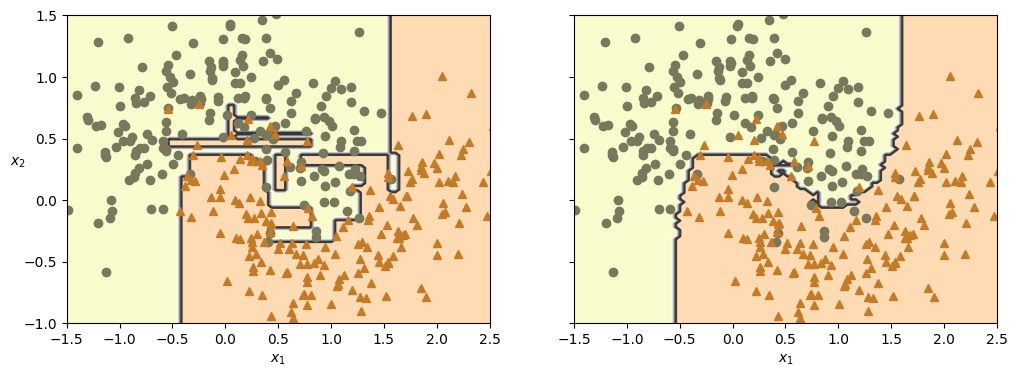

In [18]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)

plt.sca(axes[0])
plot_decision_boundary(tree_clf, X_train, y_train)
plt.ylabel("$x_2$", rotation=0)

plt.sca(axes[1])
plot_decision_boundary(bag_clf, X_train, y_train)

plt.show()

# Out-of-Bag Evaluation

You can set `oob_score=True` to have an automatic OOB evaluation after training. The result can be accessed via the `oob_score_` attribute.

In [19]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators=500,
    oob_score=True,
    n_jobs=-1,
    random_state=42,
)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.896

Our model thinks its accuracy is about 89.6%. Let's see how it actually performs on the test set.

In [20]:
bag_clf.score(X_test, y_test)

0.92

Well, looks like our model is a bit pessimistic.

We can also ask for OOB decision function for each training instance, using the `oob_decision_function_` attribute. Because the base estimators has a `predict_proba()` method, the decision function returns the estimated probability for each instance.

In [21]:
bag_clf.oob_decision_function_[:3]

array([[0.32352941, 0.67647059],
       [0.3375    , 0.6625    ],
       [1.        , 0.        ]])

# Random Forests

Here, we train a random forest with 500 decision trees, each with maximum 16 leaf nodes and utilize to use every possible CPUs.

In [22]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(
    n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42
)

forest_clf.fit(X_train, y_train)
y_predict_forest = forest_clf.predict(X_test)

With a few exceptions, `RandomForestClassifier` has all the hyperparameters of a `DecisionTreeClassifier` (to control how the trees are grown) and all the hyperparameters from a `BaggingClassifier` to control the ensemble itself.

As explained in the note.md, this bagging classifier is equivalent to our previous random forest.

In [23]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500,
    n_jobs=-1,
    random_state=42,
)

In [24]:
# Verify that bag_clf is indeed equivalent to forest_clf
bag_clf.fit(X_train, y_train)
y_predict_bag = bag_clf.predict(X_test)
np.all(y_predict_bag == y_predict_forest)

True

## Extra-Trees

You can have an extra-trees simply by setting `splitter="random"` in `DecisionTreeClassifier`.

In [25]:
BaggingClassifier(DecisionTreeClassifier(splitter="random"))

BaggingClassifier(estimator=DecisionTreeClassifier(splitter='random'))

There is an API for extra-trees in Scikit-learn, `ExtraTreesClassifier` class. Its hyperparameters is similar to `RandomForestClassifier`, expect `bootstrap=False` by default. Simlairly, there is `ExtraTreesRegressor` class for regression tasks.

## Features Importance

This code cell trains a random forest on the iris dataset and outputs each features' importances.

In [26]:
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)
forest_clf = RandomForestClassifier(n_estimators=500, random_state=42)
forest_clf.fit(iris.data, iris.target)
for important, name in sorted(
    zip(forest_clf.feature_importances_, iris.data.columns), reverse=True
):
    print(round(important * 100, 3), "%", name)

44.103 % petal length (cm)
42.336 % petal width (cm)
11.249 % sepal length (cm)
2.312 % sepal width (cm)


So the most important features are petal length (44.1%) and petal width (42.3%), while sepal width (11.2%) and sepal length (2.3%) are not really important. This is also the reason why we only talk about petal length and petal width in previous notebooks.

Similarly, we consider the MNIST dataset and plot the importance of each pixel.

In [27]:
from sklearn.datasets import fetch_openml

X_mnist, y_mnist = fetch_openml(
    "mnist_784", return_X_y=True, as_frame=True, parser="auto"
)

forest_clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
forest_clf.fit(X_mnist, y_mnist)

RandomForestClassifier(n_jobs=-1, random_state=42)

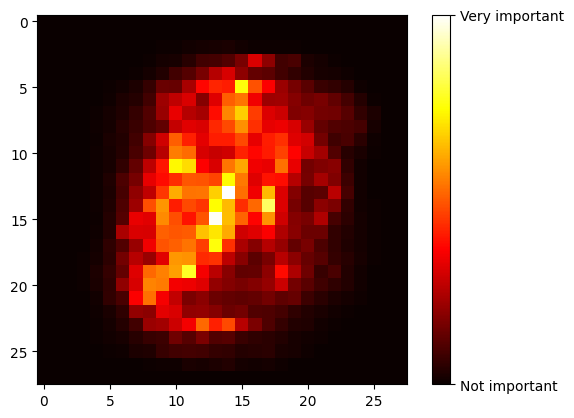

In [28]:
heatmap_image = forest_clf.feature_importances_.reshape(28, 28)
plt.imshow(heatmap_image, cmap="hot")
color_bar = plt.colorbar(
    ticks=[forest_clf.feature_importances_.min(), forest_clf.feature_importances_.max()]
)
color_bar.ax.set_yticklabels(["Not important", "Very important"])
plt.show()

# Boosting

## AdaBoost

This code cell implement AdaBoost using a highly regularized SVM with a RBF kernel. <br>
**Note:** This is for illustrative purpose only. SVMs are not good base predictors for AdaBoost, as they are slow and tend to be unstable with it.

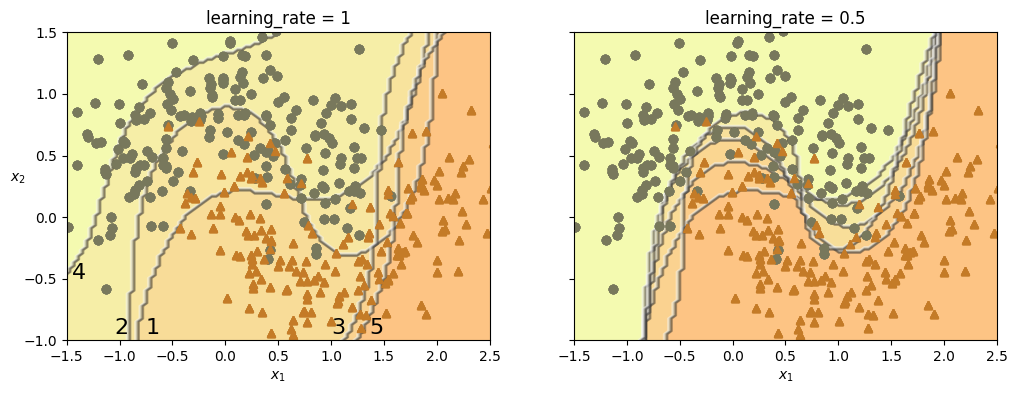

In [29]:
m = len(X_train)

fig, axes = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)

for subplot, learning_rate in [(0, 1), (1, 0.5)]:
    plt.sca(axes[subplot])
    sample_weights = np.ones(m) / m  # Initialize the sample weights

    for i in range(5):
        svm_clf = SVC(C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)
        y_predict = svm_clf.predict(X_train)

        error_weights = sample_weights[y_predict != y_train].sum()
        r = error_weights / sample_weights.sum()  # Equation 7-1
        alpha = learning_rate * np.log((1 - r) / r)  # Equation 7-2
        sample_weights[y_predict != y_train] *= np.exp(alpha)  # Equation 7-3
        sample_weights /= sample_weights.sum()

        plot_decision_boundary(svm_clf, X_train, y_train, alpha=0.4)
        plt.title(f"learning_rate = {learning_rate}")

    if subplot == 0:
        plt.text(-0.75, -0.95, "1", fontsize=16)
        plt.text(-1.05, -0.95, "2", fontsize=16)
        plt.text(1.0, -0.95, "3", fontsize=16)
        plt.text(-1.45, -0.5, "4", fontsize=16)
        plt.text(1.36, -0.95, "5", fontsize=16)
        plt.ylabel("$x_2$", rotation=0)

Of course, there is `AdaBoostClassifier` class in Scikit-learn. There also is `AdaBoostRegressor` class.

This code cell trains an `AdaBoostClassifier` based on 30 *decision stumps*.

In [30]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=30,
    learning_rate=0.5,
    random_state=42,
)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=30, random_state=42)

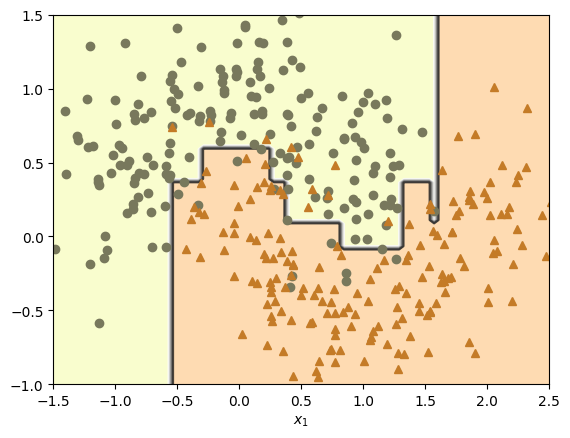

In [31]:
# In case you wonder how the decision boundary of AdaBoostClassifier looks like:
plot_decision_boundary(ada_clf, X_train, y_train)

## Gradient Boosting 

Here, we create a simple quadratic dataset and fit a `DecisionTreeRegressor` to it.

In [32]:
from sklearn.tree import DecisionTreeRegressor

np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3 * X[:, 0] ** 2 + 0.05 * np.random.randn(100)

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

Now, let's train another decision tree regressor on the residual errors made by the previous regressor.

In [33]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=43)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=43)

In [34]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=44)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=44)

In [35]:
X_new = np.array([[-0.4], [0.0], [0.5]])
sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

array([0.49484029, 0.04021166, 0.75026781])

In 

In [36]:
def plot_predictions(
    regressors, X, y, axes, style, label=None, data_style="b.", data_label=None
):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_predict = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_predict, style, label=label)
    if label or data_label:
        plt.legend(loc="upper center")
    plt.axis(axes)

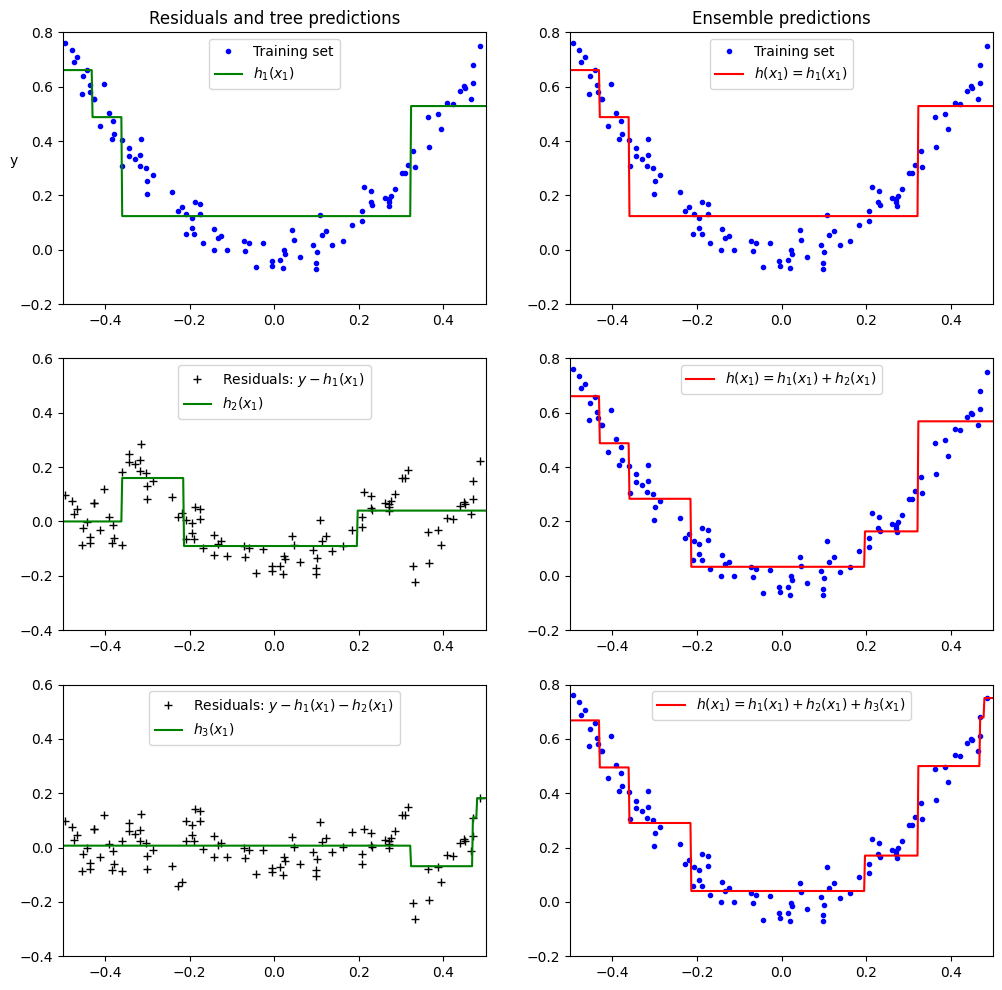

In [37]:
plt.figure(figsize=(12, 12))

plt.subplot(3, 2, 1)
plot_predictions(
    [tree_reg1],
    X,
    y,
    axes=[-0.5, 0.5, -0.2, 0.8],
    style="g-",
    label="$h_1(x_1)$",
    data_label="Training set",
)
plt.title("Residuals and tree predictions")
plt.ylabel("y", rotation=0)

plt.subplot(322)
plot_predictions(
    [tree_reg1],
    X,
    y,
    axes=[-0.5, 0.5, -0.2, 0.8],
    style="r-",
    label="$h(x_1) = h_1(x_1)$",
    data_label="Training set",
)
plt.title("Ensemble predictions")

plt.subplot(323)
plot_predictions(
    [tree_reg2],
    X,
    y2,
    axes=[-0.5, 0.5, -0.4, 0.6],
    style="g-",
    label="$h_2(x_1)$",
    data_style="k+",
    data_label="Residuals: $y-h_1(x_1)$",
)

plt.subplot(324)
plot_predictions(
    [tree_reg1, tree_reg2],
    X,
    y,
    axes=[-0.5, 0.5, -0.2, 0.8],
    style="r-",
    label="$h(x_1) = h_1(x_1) + h_2(x_1)$",
)

plt.subplot(325)
plot_predictions(
    [tree_reg3],
    X,
    y3,
    axes=[-0.5, 0.5, -0.4, 0.6],
    style="g-",
    label="$h_3(x_1)$",
    data_style="k+",
    data_label="Residuals: $y-h_1(x_1)-h_2(x_1)$",
)

plt.subplot(326)
plot_predictions(
    [tree_reg1, tree_reg2, tree_reg3],
    X,
    y,
    axes=[-0.5, 0.5, -0.2, 0.8],
    style="r-",
    label="$h(x_1) = h_1(x_1)+ h_2(x_1) + h_3(x_1)$",
)

plt.show()

Here we try a gradient boosting regressor, using `GradientBoostingRegressor` class from Scikit-learn. This gradient boosting instance is identical to the ensemble trained in the previous code cell.

In [38]:
from sklearn.ensemble import GradientBoostingRegressor

gradient_reg = GradientBoostingRegressor(
    max_depth=2,
    learning_rate=1.0,
    n_estimators=3,
    random_state=42,
)
gradient_reg.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

Here, we train another regressor, but give it a very generous limit of `n_estimators`.

In [39]:
gradient_best_reg = GradientBoostingRegressor(
    max_depth=2,
    learning_rate=0.05,
    n_estimators=500,
    n_iter_no_change=10,
    random_state=42,
)
gradient_best_reg.fit(X, y)

GradientBoostingRegressor(learning_rate=0.05, max_depth=2, n_estimators=500,
                          n_iter_no_change=10, random_state=42)

In [40]:
gradient_best_reg.n_estimators_

92

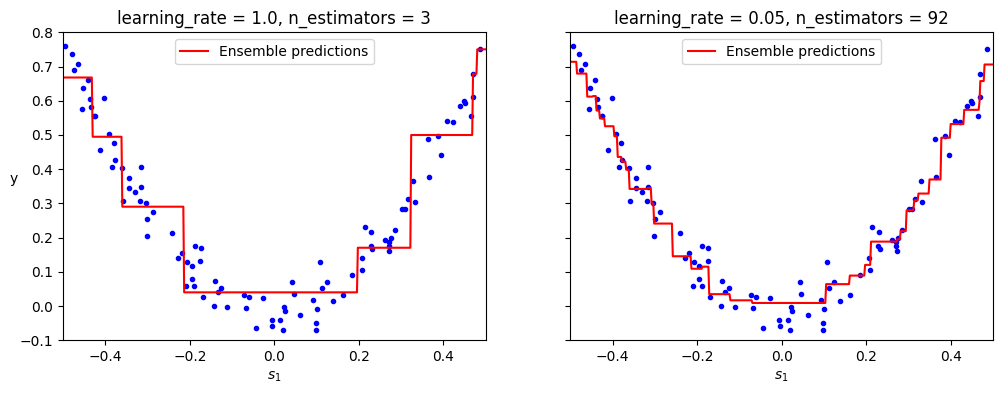

In [41]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)

plt.sca(axes[0])
plot_predictions(
    [gradient_reg],
    X,
    y,
    axes=[-0.5, 0.5, -0.1, 0.8],
    style="r-",
    label="Ensemble predictions",
)
plt.xlabel("$s_1$")
plt.ylabel("y", rotation=0)
plt.title(
    f"learning_rate = {gradient_reg.learning_rate}, n_estimators = {gradient_reg.n_estimators_}"
)

plt.sca(axes[1])
plot_predictions(
    [gradient_best_reg],
    X,
    y,
    axes=[-0.5, 0.5, -0.1, 0.8],
    style="r-",
    label="Ensemble predictions",
)
plt.xlabel("$s_1$")
plt.title(
    f"learning_rate = {gradient_best_reg.learning_rate}, n_estimators = {gradient_best_reg.n_estimators_}"
)

plt.show()

The following code cell just loads the California housing dataset, which we discussed in chapter 2.

In [48]:
from sklearn.model_selection import train_test_split
import tarfile
import urllib.request
from pathlib import Path
from typing import Tuple


def load_housing_data():
    tar_path = Path("datasets/housing.tgz")
    if not tar_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tar_path)
        with tarfile.open(tar_path) as housing_files_all:
            housing_files_all.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))


housing = load_housing_data()

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
train_set: pd.DataFrame
test_set: pd.DataFrame
housing_labels = train_set["median_house_value"]
housing = train_set.drop("median_house_value", axis=1)

The following code cell build and train a complete pipeline for the California housing dataset.

In [49]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import OrdinalEncoder

hig_reg = make_pipeline(
    make_column_transformer(
        (OrdinalEncoder(), ["ocean_proximity"]), remainder="passthrough"
    ),
    HistGradientBoostingRegressor(categorical_features=[0], random_state=42),
)

hig_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['ocean_proximity'])])),
                ('histgradientboostingregressor',
                 HistGradientBoostingRegressor(categorical_features=[0],
                                               random_state=42))])

The whole pipeline is extremely short, as you can compare it with the chapter 2's learning [notebook](../Chapter%202/housing.ipynb). No need to for an imputer, scaler, or an one-hot encoder. <br> 
Note that categorical_features must be set to the categorical column indices (or a Boolean array).

The following code evaluate this pipeline using `cross_val_score` and give us a rough description about the scores.

In [51]:
from sklearn.model_selection import cross_val_score

hgb_rmse = -cross_val_score(
    hig_reg, housing, housing_labels, scoring="neg_root_mean_squared_error", cv=10
)
pd.Series(hgb_rmse).describe()

count       10.000000
mean     47613.307194
std       1295.422509
min      44963.213061
25%      47001.233485
50%      48000.963564
75%      48488.093243
max      49176.368465
dtype: float64

And we have a model with an RMSE about 47600, which is not too bad.